# Numerical modelling of a truss

This notebook is a guide to create your own code for solving a generic truss problem. 
To solve some of the **Exercices** below you can look at the notebook $01-LinearBeam$

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy.interactive import printing
printing.init_printing()
%matplotlib inline

Let us consider here the simple case of a truss (*treillis*) where the bars are without bending and shear stresses. We introduce some symbols to be used later:

In [2]:
L, s, ES, alpha = sp.symbols('L, s, ES, alpha')

The geometry of a truss can be assigned through a collection of nodes and elements. Example:

In [3]:
nodes = np.array([[0.,0.],[4.,0.],[7.,0.],[4.,3.]])
elements = np.array([[0,1],[1,2],[2,3],[0,3],[1,3]])

We define a Truss `class` (see https://openclassrooms.com/courses/apprenez-a-programmer-en-python/premiere-approche-des-classes) collecting its nodes and elements and useful methods for their analysis.

In [4]:
class Truss():
    """
    This class implements a model for a linear model of a planar truss.
    """

    def __init__(self, nodes, elements):
        """
        Define a planar truss structure given an array of nodes and an array of elements.

        input:
         - nodes:  a nnodes x 2 np.array list of point coordinates
         - elements: a nelements x 2 list of integers, given the node numbers defining each element
        """
        self.nodes = nodes
        self.elements = elements
        self.nnodes = self.nodes.shape[0]
        self.nelements = self.elements.shape[0]
        self.ndof = 2*self.nnodes
        self.Ls = np.array([self.L(e) for e in range(self.nelements)])
        self.angles = np.array([self.angle(e) for e in range(self.nelements)])
        # set default values for stiffness and loadings
        self.ES = 1*np.ones(self.nelements)
        # initialize to 0 the displacement
        self.U = np.zeros(self.ndof)
        print("Truss with")
        print("%i elements"%self.nelements)
        print("%i nodes"%self.nnodes)
        print("%i dofs"%self.ndof)

    def L(self, e):
        """
        Returns the length of the element e
        """
        dx = self.nodes[self.elements[e]][1]-self.nodes[self.elements[e]][0]
        return np.sqrt(dx[0]**2+dx[1]**2)
    
    def plot(self, label=True):
        """
        plot the frame
        """
        fig, ax = plt.subplots()
        nodes = self.nodes
        elements = self.elements
        shift = nodes.max()*.02
        for (e_num,e) in enumerate(elements):
            xcoords = nodes[e][:,0]
            ycoords = nodes[e][:,1]
            ax.plot(xcoords, ycoords,'o-',lw=2, color='black', ms=10)
            if label:
                ax.text((xcoords[0]+xcoords[1])/2.+shift, (ycoords[0]+ycoords[1])/2.+shift,
                        str(e_num), bbox=dict(facecolor='yellow'))
                for i in range(e.size):
                    ax.text(xcoords[i]+shift, ycoords[i]+shift, e[i],
                            verticalalignment = 'bottom', horizontalalignment = 'left')
        ax.set_xlim(nodes[:,0].min()-10*shift, nodes[:,0].max()+10*shift)
        ax.set_ylim(nodes[:,1].min()-10*shift, nodes[:,1].max()+10*shift)
        ax.set_aspect('equal', 'datalim')
        return ax
    
    def dof_map_e(self,e):
        """
        Returns the list of global dofs for the element e
        """
        return np.array([self.elements[e,0]*2, self.elements[e,0]*2+1,
                     self.elements[e,1]*2, self.elements[e,1]*2+1])

    def dof_map(self,e,i_local):
        """
        Returns the global dof corresponding to the local dof i_local in the element e
        """
        return self.dof_map_e(e)[i_local]
    
    def angle(self, e):
        """
        Returns the orientation angle of the element e
        """
        coord = self.nodes[self.elements[e]]
        delta = coord[1]-coord[0]
        angle = np.arctan2(delta[1],delta[0])
        return angle

We can then create an object truss, instance of the `Truss` class and plot its shape 

Truss with
5 elements
4 nodes
8 dofs


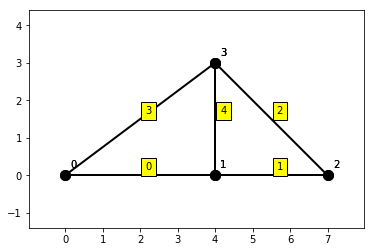

In [5]:
truss = Truss(nodes,elements)
truss.plot()

** Exercice 0: ** Add to the `Truss` class a method `angle` to define the angle $\alpha$ defining the orientation of each bar in the global coordinate system and modify the initiatialization of the class to add the class an attribute `angles` collecting in a numpy vector the orientation angle of all the elements. 

# Local and global coordinates

Let us denote by $\underline{t_e}$ and $\underline{n_e}$ the unit vectors tangential and orthogonal to the bar $e$, connecting the nodes $i$ and $j$. For each bar there are two relevant choice of the reference frame:

* The **global reference frame** (0,$\underline e_1$,$\underline e_2$) 

* The **local reference frame** (i,$\underline t_e$,$\underline n_e$) 

The displacement of each point of the bar can then be written as:
$$
\underline u(s) = u_x(s) \underline e_1 + u_y(s) \underline e_2 =
 u_t(s) \underline t_e + u_n(s) \underline n_e
$$
where $U_g=[u_x,u_y]^T$ and $U_l=[u_t,u_n]^2$ are the global and local compontents, respectively. 

** Exercice 1 ** 
Show that 
$$
U_g = R U_l
$$
where the change of coordinate matrix $R$ is:

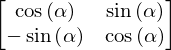

In [6]:
R = sp.Matrix([[sp.cos(alpha),sp.sin(alpha)],[-sp.sin(alpha),sp.cos(alpha)]])
R

# Energy and stiffness matrix

The normal stress in each bar is a constant, $N_e$, the deformation is $\varepsilon_e=N_e/ES=\Delta L/L$, where $L$ is the length of the bar and  $\Delta L=u_t(L)-u_t(0)=u_t^{(j)}-u_t^{(i)}$ its elongation, the superscript referring to the node number. 
The elastic energy of the bar $e$ is 
$$
\mathcal{E}_e=\int_0^L ES \varepsilon_e(x)^2\mathrm{d}x 
$$

**Exercice 2** Assuming that the axial displacement in each bar is in the form (linear approximation):
$$
\underline u(s) = \left(\frac{s}{L} u_t^{(j)} +  \frac{L-s}{L}u_t^{(i)}\right)\underline{t}
$$
show that the elastic energy of each bar can be written in the form
$$
\mathcal{E}_e=\dfrac{1}{2}K^{(e)}_l U_l\cdot U_l=\dfrac{1}{2}K^{(e)}_g U_g\cdot U_g
$$
where the coordinate representation of the local stiffness matrix $K_e$ in the local  coordinate systems is:

In [ ]:
S = sp.Matrix([1 - s/L, 0, s/L, 0])
B = sp.Matrix(S.diff(s,1))
# Local stifnness in local coordinate
Ke_l = ES*sp.integrate(B*B.transpose(),(s,0,L))
Ke_l

Determine the representation of the local stiffnness in the global reference frame (the code below should be completed)

In [8]:
# Local stifnness in global coordinate
Re = 
Ke_g = Re*Ke_l*Re.transpose()
Ke_g

SyntaxError: invalid syntax (<ipython-input-8-9a8ec5f4158a>, line 2)

Let us define the global displacement vector $U$ collecting the displacement of all the nodes in the global coordinate systems:
$$
U = \begin{bmatrix}
u_x^{(1)}\\
u_y^{(1)}\\
\vdots\\
u_x^{(i)}\\
u_y^{(i)}\\
\vdots\\
u_x^{(n)}\\
u_y^{(n)}\\
\end{bmatrix}
$$


**Exercise 3**: 
Let us define the global stiffness matrix $K$ in the global coordinate system as the matrix $K$ such that the total elastic energy of the truss is:
$$
\mathcal E = \sum_{el=1}\dfrac{1}{2}K^{(e)} U^{(e)}\cdot U^{(e)} = \dfrac{1}{2}K U\cdot U
$$
Write a function `assemble_stifness(truss)`

# Load vector

** Exercice **
Consider the loading in the form of forces concentrated at nodes. Let  $F_x^{i}$ and $F_y^{i}$ be the global coordiantes of the forces at node $i$. Determine the expression of the global load vector. 

# Solve 

**Exercice**
Determine the solution of the linear system $K U = F$, imposing the appropiate boundary conditions.

# Postprocessing 
**Exercice**
1. Add a method to the truss class to visualize the shape of the truss after applyin the nodal displacement vector $U$.
2. Add a method to the truss class to determine the normal stress in each bar

# Verification 

**Exercice**
Choose a simple test problem to verify your code (for example the TP in St.Cyr on the Von Mises truss).

# Encapsulation

**Exercice** Encapsulate all the code necessary and sufficient to solve a truss problem in the `Truss` class and put it a `truss.py` python file. Solve an example in a separate jupyter notebook by importing `truss` as a python module and using its `Truss` class. 